In [1]:
import os
import re
from html import unescape
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [2]:
from google.colab import drive
file_path = '/content/drive/MyDrive/Project-7/twitter_disaster.csv'
df = pd.read_csv(file_path)
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
# Paths
FILE_PATH = '/content/drive/MyDrive/Project-7/twitter_disaster.csv'
TFIDF_OUT = '/content/drive/MyDrive/Project-7/tfidf_vectorizer.joblib'
MODEL_OUT = '/content/drive/MyDrive/Project-7/best_model.joblib'

RANDOM_STATE = 42
TEST_SIZE = 0.20

def clean_text(s):
    """Basic tweet cleaning."""
    if pd.isna(s):
        return ""
    s = str(s)
    s = unescape(s)
    # remove urls
    s = re.sub(r'http\S+|www\.\S+', ' ', s)
    # remove mentions
    s = re.sub(r'@\w+', ' ', s)
    # remove hashtag symbol but keep text
    s = re.sub(r'#', ' ', s)
    # remove non-alphanumeric (keep spaces)
    s = re.sub(r'[^0-9A-Za-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip().lower()
    return s

# == Load dataset ==
assert os.path.exists(FILE_PATH), f"Dataset not found at {FILE_PATH}. Upload it (see earlier cell)."
#df = pd.read_csv(FILE_PATH)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing per column:\n", df.isnull().sum())

# Detect text and target columns robustly if names differ
text_col = None
target_col = None
for c in df.columns:
    if c.lower() == 'text':
        text_col = c
    if c.lower() in ('target','label','is_disaster'):
        target_col = c
# fallback
if text_col is None:
    text_candidates = [c for c in df.columns if 'text' in c.lower()]
    text_col = text_candidates[0] if text_candidates else None
if target_col is None:
    # often 'target' exists
    tgt_candidates = [c for c in df.columns if c.lower() in ('target','label','is_disaster','disaster') or c.lower().startswith('target')]
    target_col = tgt_candidates[0] if tgt_candidates else None

if text_col is None or target_col is None:
    raise ValueError(f"Couldn't auto-detect text or target columns. Detected: text_col={text_col}, target_col={target_col}. Please ensure your CSV has 'text' and 'target' columns.")

print("Using text column:", text_col, "and target column:", target_col)

Dataset shape: (7613, 5)
Columns: ['id', 'keyword', 'location', 'text', 'target']
Missing per column:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Using text column: text and target column: target


In [4]:
# == Quick EDA ==
print("\nSample rows:")
display(df.head(5))

print("\nClass distribution:")
print(df[target_col].value_counts())

# == Clean ==
df['clean_text'] = df[text_col].apply(clean_text)
display(df[['clean_text']].head(6))

# == Split ==
X = df['clean_text'].fillna("")
y = df[target_col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# == TF-IDF ==
tfv = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english', min_df=3)
X_train_tfidf = tfv.fit_transform(X_train)
X_test_tfidf = tfv.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# == Train models ==
print("\nTraining LogisticRegression...")
log = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log.fit(X_train_tfidf, y_train)

print("Training RandomForest...")
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_tfidf, y_train)

# == Evaluate ==
models = {'LogisticRegression': log, 'RandomForest': rf}
results = []
for name, model in models.items():
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    rep = classification_report(y_test, preds, zero_division=0, output_dict=True)
    # get positive class metrics
    f1_pos = rep.get('1', {}).get('f1-score', rep.get('positive', {}).get('f1-score', None))
    precision_pos = rep.get('1', {}).get('precision', rep.get('positive', {}).get('precision', None))
    recall_pos = rep.get('1', {}).get('recall', rep.get('positive', {}).get('recall', None))
    # ROC AUC if possible
    try:
        probs = model.predict_proba(X_test_tfidf)[:,1]
        rocauc = roc_auc_score(y_test, probs)
    except Exception:
        probs = None
        rocauc = None
    results.append({
        'model': name,
        'accuracy': acc,
        'precision_pos': precision_pos,
        'recall_pos': recall_pos,
        'f1_pos': f1_pos,
        'roc_auc': rocauc,
        'model_obj': model,
        'probs': probs
    })

res_df = pd.DataFrame([{k:v for k,v in r.items() if k not in ('model_obj','probs')} for r in results])
display(res_df)

# Choose best by f1_pos
best = max(results, key=lambda r: (r['f1_pos'] if r['f1_pos'] is not None else -1))
best_name = best['model']
best_model = best['model_obj']
print("\nBest model (by positive-class F1):", best_name)

# Detailed report for best model
from sklearn.metrics import classification_report, confusion_matrix
y_pred_best = best_model.predict(X_test_tfidf)
print("\nClassification report (best model):\n")
print(classification_report(y_test, y_pred_best, zero_division=0))
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred_best))


Sample rows:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



Class distribution:
target
0    4342
1    3271
Name: count, dtype: int64


,clean_text
0,our deeds are the reason of this earthquake ma...
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...
3,13 000 people receive wildfires evacuation ord...
4,just got sent this photo from ruby alaska as s...
5,rockyfire update california hwy 20 closed in b...



Train size: 6090, Test size: 1523
TF-IDF shapes: (6090, 5129) (1523, 5129)

Training LogisticRegression...
Training RandomForest...


,model,accuracy,precision_pos,recall_pos,f1_pos,roc_auc
0,LogisticRegression,0.822062,0.850091,0.711009,0.774355,0.868529
1,RandomForest,0.794485,0.795494,0.701835,0.745735,0.851004



Best model (by positive-class F1): LogisticRegression

Classification report (best model):

              precision    recall  f1-score   support

           0       0.81      0.91      0.85       869
           1       0.85      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523


Confusion matrix (rows=true, cols=pred):
[[787  82]
 [189 465]]


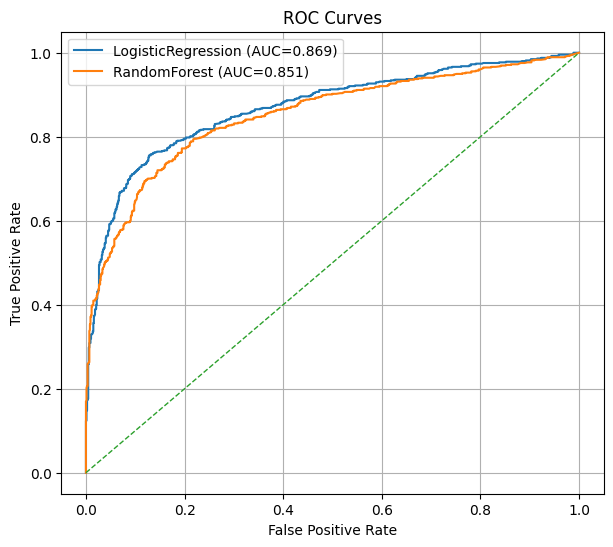

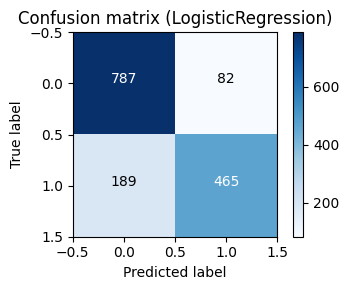


Top positive features (indicative of disaster):
[('hiroshima', np.float64(3.4305)), ('california', np.float64(2.7826)), ('killed', np.float64(2.4657)), ('wildfire', np.float64(2.3722)), ('fires', np.float64(2.3719)), ('buildings', np.float64(2.3425)), ('storm', np.float64(2.3291)), ('earthquake', np.float64(2.1635)), ('suicide', np.float64(2.1596)), ('police', np.float64(2.1181)), ('forest', np.float64(2.1078)), ('near', np.float64(2.1017)), ('floods', np.float64(2.0639)), ('train', np.float64(2.055)), ('typhoon', np.float64(2.0044)), ('japan', np.float64(1.9829)), ('bombing', np.float64(1.9396)), ('massacre', np.float64(1.9302)), ('mh370', np.float64(1.842)), ('debris', np.float64(1.8362))]

Top negative features (indicative of non-disaster):
[('love', np.float64(-2.0097)), ('new', np.float64(-1.8058)), ('ruin', np.float64(-1.6024)), ('bloody', np.float64(-1.5011)), ('wrecked', np.float64(-1.5)), ('harm', np.float64(-1.4815)), ('explode', np.float64(-1.4688)), ('let', np.float64(-1.4

,text,clean,pred,prob_positive
0,There's a forest fire coming towards the town ...,there s a forest fire coming towards the town ...,1,0.606438
1,"I love hiking in the mountains, beautiful day!",i love hiking in the mountains beautiful day,0,0.135135
2,"Explosion at the mall, many injured",explosion at the mall many injured,1,0.758623
3,"Just watched a movie about a flood, so sad",just watched a movie about a flood so sad,0,0.390500


In [5]:
# == ROC curve(s) ==
plt.figure(figsize=(7,6))
plotted_any = False
for r in results:
    name = r['model']
    probs = r['probs']
    if probs is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plotted_any = True
if plotted_any:
    plt.plot([0,1],[0,1],'--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Couldn't compute ROC for any model (no probability outputs).")

# == Confusion matrix heatmap for best model ==
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion matrix ({best_name})")
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# == Top features for logistic regression (if best_model is logistic) ==
try:
    if hasattr(log, "coef_"):
        feat_names = np.array(tfv.get_feature_names_out())
        coef = log.coef_[0]
        top_pos_idx = np.argsort(coef)[-20:][::-1]
        top_neg_idx = np.argsort(coef)[:20]
        print("\nTop positive features (indicative of disaster):")
        print(list(zip(feat_names[top_pos_idx], np.round(coef[top_pos_idx], 4))))
        print("\nTop negative features (indicative of non-disaster):")
        print(list(zip(feat_names[top_neg_idx], np.round(coef[top_neg_idx], 4))))
except Exception as e:
    print("Could not extract top features:", e)

# == Save artifacts ==
joblib.dump(tfv, TFIDF_OUT)
joblib.dump(best_model, MODEL_OUT)
print("\nSaved TF-IDF to:", TFIDF_OUT)
print("Saved best model to:", MODEL_OUT)

# == Sample predictions ==
sample_texts = [
    "There's a forest fire coming towards the town please help",
    "I love hiking in the mountains, beautiful day!",
    "Explosion at the mall, many injured",
    "Just watched a movie about a flood, so sad"
]
sample_clean = [clean_text(s) for s in sample_texts]
sample_tfidf = tfv.transform(sample_clean)
sample_preds = best_model.predict(sample_tfidf)
sample_probs = best_model.predict_proba(sample_tfidf)[:,1] if hasattr(best_model, "predict_proba") else [None]*len(sample_preds)
sample_df = pd.DataFrame({
    "text": sample_texts,
    "clean": sample_clean,
    "pred": sample_preds,
    "prob_positive": sample_probs
})
display(sample_df)

In [6]:
from sklearn.model_selection import cross_val_score

# Use 5-fold cross validation on training data
cv_scores = cross_val_score(best_model, X_train_tfidf, y_train, cv=5, scoring='f1')
print("Cross-validation F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean(), "Std:", cv_scores.std())

Cross-validation F1 scores: [0.73196986 0.73269436 0.71287129 0.73560768 0.74369748]
Mean CV F1: 0.7313681315577257 Std: 0.010141407653021014


If CV scores are consistent and close to the test score, the model is not overfitting badly.

In [7]:
from sklearn.metrics import f1_score

# Training performance
train_preds = best_model.predict(X_train_tfidf)
train_f1 = f1_score(y_train, train_preds)
train_acc = accuracy_score(y_train, train_preds)

# Testing performance (already computed)
test_preds = y_pred_best
test_f1 = f1_score(y_test, test_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy={train_acc:.3f}, Train F1={train_f1:.3f}")
print(f"Test Accuracy={test_acc:.3f}, Test F1={test_f1:.3f}")

Train Accuracy=0.865, Train F1=0.828
Test Accuracy=0.822, Test F1=0.774


If train >> test, model may be overfitting. If both are low, model is underfitting. If both are moderate and close, model is generalizing well.

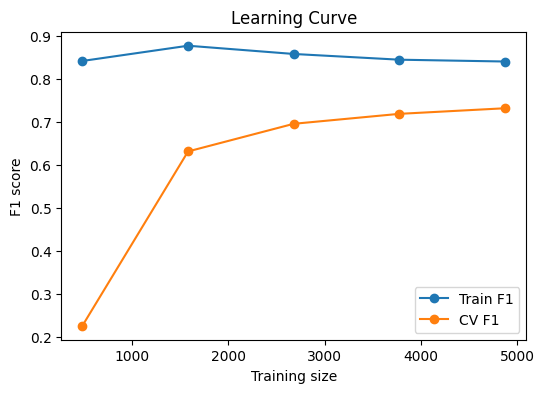

In [8]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_tfidf, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label="Train F1")
plt.plot(train_sizes, test_mean, 'o-', label="CV F1")
plt.xlabel("Training size")
plt.ylabel("F1 score")
plt.title("Learning Curve")
plt.legend()
plt.show()


If training and validation curves converge and stabilize at a good score → robust model.

If large gap persists → overfitting.

If both are low → underfitting.

In [9]:
robustness_samples = [
    "FIRE in da building!!! 😱😱 #help",
    "earthquake in town, people running everywhere",
    "Nice sunny day ☀️ at the beach",
    "Explosionnnnn happened downtownnnn!!!"
]

cleaned = [clean_text(s) for s in robustness_samples]
X_robust = tfv.transform(cleaned)
preds = best_model.predict(X_robust)
probs = best_model.predict_proba(X_robust)[:,1]

pd.DataFrame({
    "original": robustness_samples,
    "cleaned": cleaned,
    "pred": preds,
    "prob_positive": probs
})

,original,cleaned,pred,prob_positive
0,FIRE in da building!!! 😱😱 #help,fire in da building help,0,0.358216
1,"earthquake in town, people running everywhere",earthquake in town people running everywhere,1,0.682631
2,Nice sunny day ☀️ at the beach,nice sunny day at the beach,0,0.177054
3,Explosionnnnn happened downtownnnn!!!,explosionnnnn happened downtownnnn,0,0.382854


In [10]:
# == Save artifacts ==
joblib.dump(tfv, TFIDF_OUT)
joblib.dump(best_model, MODEL_OUT)
print("\nSaved TF-IDF to:", TFIDF_OUT)
print("Saved best model to:", MODEL_OUT)


Saved TF-IDF to: /content/drive/MyDrive/Project-7/tfidf_vectorizer.joblib
Saved best model to: /content/drive/MyDrive/Project-7/best_model.joblib


In [11]:
from flask import Flask, request, render_template, jsonify
import joblib
from pathlib import Path
import re
from html import unescape

# ==== Load artifacts ====
# Use the paths defined earlier in the notebook
MODEL_PATH = Path(MODEL_OUT)
VECT_PATH = Path(TFIDF_OUT)

model = joblib.load(MODEL_PATH)
tfv = joblib.load(VECT_PATH)

# ==== Text cleaner (same as training) ====
def clean_text(text: str) -> str:
    if text is None:
        return ""
    s = str(text)
    s = unescape(s)
    s = re.sub(r'http\S+|www\.\S+', ' ', s)
    s = re.sub(r'@\w+', ' ', s)
    s = re.sub(r'#', ' ', s)
    s = re.sub(r'[^0-9A-Za-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s.strip().lower()

# ==== Flask app ====
app = Flask(__name__)

@app.route("/", methods=["GET", "POST"])
def index():
    prediction = None
    prob = None
    text = ""
    if request.method == "POST":
        text = request.form.get("tweet", "")
        cleaned = clean_text(text)
        X = tfv.transform([cleaned])
        pred = int(model.predict(X)[0])
        prob = float(model.predict_proba(X)[:,1][0]) if hasattr(model, "predict_proba") else None
        prediction = "🚨 Disaster" if pred == 1 else "✅ Not Disaster"
    return render_template_string("""
<!DOCTYPE html>
<html>
<head>
  <title>Disaster Tweet Classifier</title>
  <style>
    body { font-family: Arial, sans-serif; margin: 2em; }
    input[type=text] { width: 80%; padding: 0.5em; }
    button { padding: 0.5em 1em; margin-left: 1em; }
    .result { margin-top: 1em; font-size: 1.2em; }
  </style>
</head>
<body>
  <h1>🚨 Disaster Tweet Classifier</h1>
  <form method="POST">
    <input type="text" name="tweet" placeholder="Enter a tweet..." value="{{ text }}">
    <button type="submit">Predict</button>
  </form>

  {% if prediction %}
  <div class="result">
    <b>Prediction:</b> {{ prediction }} <br>
    {% if prob %}<b>Probability (Disaster):</b> {{ "%.2f"|format(prob) }}{% endif %}
  </div>
  {% endif %}
</body>
</html>
""", prediction=prediction, prob=prob, text=text)


@app.route("/predict", methods=["POST"])
def api_predict():
    data = request.get_json(force=True)
    if not data or "text" not in data:
        return jsonify({"error": "Provide 'text' in JSON"}), 400
    text = data["text"]
    cleaned = clean_text(text)
    X = tfv.transform([cleaned])
    pred = int(model.predict(X)[0])
    prob = float(model.predict_proba(X)[:,1][0]) if hasattr(model, "predict_proba") else None
    return jsonify({"text": text, "cleaned": cleaned, "pred": pred, "prob_positive": prob})

if __name__ == "__main__":
    # To run this in Colab, you'll typically use ngrok or a similar service
    # For a simple test within Colab, you might not run this block directly,
    # but rather call the functions or use a tool like flask-ngrok.
    # app.run(host="0.0.0.0", port=5000, debug=True)
    pass # Added pass to avoid running the Flask server directly in Colab

In [12]:
!curl https://cli-assets.heroku.com/install.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1979  100  1979    0     0  17096      0 --:--:-- --:--:-- --:--:-- 17208
Installing CLI from https://cli-assets.heroku.com/channels/stable/heroku-linux-x64.tar.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58.5M  100 58.5M    0     0  6933k      0  0:00:08  0:00:08 --:--:-- 7076k
v20.19.5
heroku installed to /usr/local/bin/heroku
 ›   Warning: Our terms of service have changed: 
 ›   https://dashboard.heroku.com/terms-of-service
heroku/10.13.2 linux-x64 node-v20.19.5


In [19]:
!git init
!git add .
!git commit -m "Initial commit"
!git config user.email "dc.datascientist@gmail.com"
!git config user.name "Dinesh"
!heroku create disaster-tweet-classifier
!git push heroku master

Reinitialized existing Git repository in /content/.git/
[master (root-commit) 76ca40f] Initial commit
 55 files changed, 2271356 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.09.23/13.38.43.223527.log
 create mode 100644 .config/logs/2025.09.23/13.39.03.759788.log
 create mode 100644 .config/logs/2025.09.23/13.39.12.687807.log
 create mode 100644 .config/logs/2025.09.23/13.39.13.933616.log
 create mode 100644 .config/logs/2025.09.23/13.39.22.846782.log
 create mode 100644 .config/logs/2025.09.23/13.39.23.609744.log
 

In [17]:
!heroku open

 ›   Error: The following error occurred:
 ›     Missing required flag app
 ›   See more help with --help
